# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as mtplt
import cv2
import os
import random
import shutil


# Data pre-processing

In [2]:
head_file = r'C:\Users\fyrza\Documents\FYP\DATASET\data18\data'
#Label
classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

    #Resize the dataset images into 100 x 100 px
#Loop through folders
for file in os.listdir(head_file):
    #Loop through images in each class
    for image in os.listdir(os.path.join(head_file, file)):
            image_path = os.path.join(head_file, file, image)  
            
            #Read images
            img = cv2.imread(image_path)
            
            #Convert image to grayscale
            grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            #Thresholding and erosion/dilation
            _, binaryimg = cv2.threshold(grayimg, 15, 255, cv2.THRESH_BINARY)
            kernel = np.ones((7, 7), np.uint8)
            binaryimg = cv2.morphologyEx(binaryimg, cv2.MORPH_OPEN, kernel)
            
            #Find contours and select the largest contour
            contours, _ = cv2.findContours(binaryimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            largestcontour = max(contours, key=cv2.contourArea)
            
            #Find extreme points
            left = tuple(largestcontour[largestcontour[:, :, 0].argmin()][0])
            right = tuple(largestcontour[largestcontour[:, :, 0].argmax()][0])
            top = tuple(largestcontour[largestcontour[:, :, 1].argmin()][0])
            bottom = tuple(largestcontour[largestcontour[:, :, 1].argmax()][0])
            
            # Crop the image
            cropimg = img[top[1]:bottom[1], left[0]:right[0]]
            imgs = cv2.cvtColor(cropimg, cv2.COLOR_BGR2GRAY)
            
            #Apply median filtering to reduce salt-pepper noise
            kernels = 3
            blurimg = cv2.medianBlur(imgs, kernels)
            
            #Apply CLAHE to enhance mri contrast
            clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
            claheimg = clahe.apply(blurimg)
             
            #Resize image
            rszimg = cv2.resize(claheimg, (100,100))
            cv2.imwrite(image_path,rszimg)
                      
print("Pre-processed complete")

Pre-processed complete


# Data Splitting

In [3]:
#Data Splitting

file = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
#Main data directory
data_dir = r'C:\Users\fyrza\Documents\FYP\DATASET\data18\data'

for i in file:
    os.makedirs(data_dir+'/train/'+i)
    os.makedirs(data_dir+'/test/'+i)
    os.makedirs(data_dir+'/validation/'+i)
    source = data_dir+'/'+i
    allFileNames = os.listdir(source)
    np.random.shuffle(allFileNames)
    test_ratio = 0.2
    
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(1-test_ratio))])
    test_FileNames, val_FileNames = np.split(np.array(test_FileNames), [int(len(test_FileNames)/2)])
    
    train_FileNames = [source+'/'+name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/'+name for name in test_FileNames.tolist()]
    val_FileNames = [source+'/'+name for name in val_FileNames.tolist()]
    
    for name in train_FileNames:
        shutil.copy(name, data_dir+'/train/'+i)
    for name in test_FileNames:
        shutil.copy(name,data_dir+'/test/'+i)
    for name in val_FileNames:
        shutil.copy(name,data_dir+'/validation/'+i)

In [4]:
train_path = r'C:\Users\fyrza\Documents\FYP\DATASET\data18\data\train'
test_path = r'C:\Users\fyrza\Documents\FYP\DATASET\data18\data\test'
val_path = r'C:\Users\fyrza\Documents\FYP\DATASET\data18\data\validation'

In [5]:
#Data augmentation
countsbefore = {}
for cls in classes:
    classfolder = os.path.join(train_path, cls)
    num_images_before = len([f for f in os.listdir(classfolder) if f.endswith(('.jpg', '.jpeg'))])
    countsbefore[cls] = num_images_before


augImages = {"ModerateDemented": 1285}

augimage = []
auglabel = []


#Loop to augment only Moderate 
for classname, numaug, in augImages.items():
    classfolder = os.path.join(train_path, classname)
    
    train_datagen = ImageDataGenerator(rotation_range = 30,
                                         horizontal_flip = True, 
                                         width_shift_range = 0.1, 
                                         vertical_flip=False)
    
    numimages = len([f for f in os.listdir(classfolder) if f.endswith(('.jpg', '.jpeg'))])
    
    augperimg = numaug // numimages
    
    for filename in os.listdir(classfolder):
        if filename.endswith(('.jpg', '.jpeg')):
            filepath = os.path.join(classfolder, filename)
            img = load_img(filepath)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)    
            
            i = 0
            for batch in train_datagen.flow(x, 
                                            batch_size = 1, 
                                            save_to_dir = classfolder, 
                                            save_prefix = f'aug_{filename}', 
                                            save_format = 'jpg'):
                augim = batch[0].astype('uint8')
                augimage.append(augim)
                auglabel.append(classname)
                i += 1 
                if i >= augperimg:
                    break

countsafter = {}
for cls in classes:
    classfolder = os.path.join(train_path, cls)
    num_images_after = len([f for f in os.listdir(classfolder) if f.endswith(('.jpg', '.jpeg'))])
    countsafter[cls] = num_images_after

    

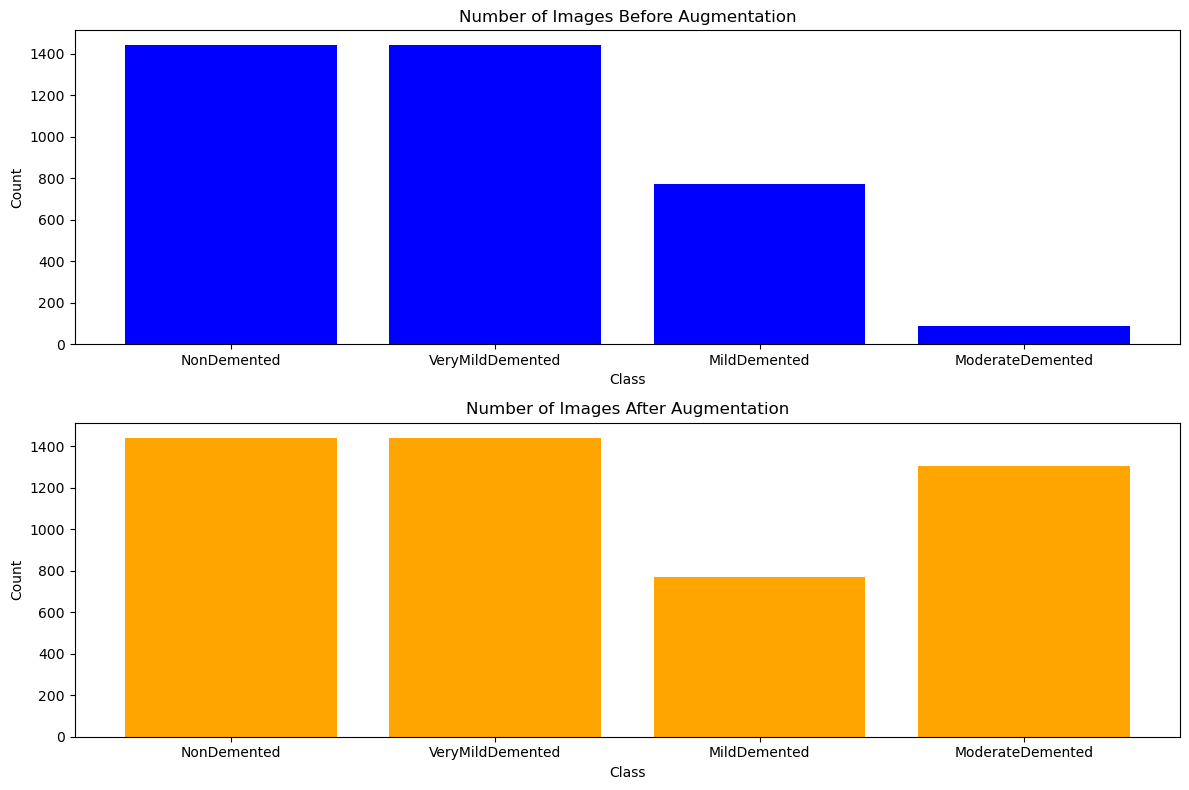

In [6]:
#Graph of before and after oversample using data augmentation
fig, axs = mtplt.subplots(2, 1, figsize=(12, 8))

axs[0].bar(countsbefore.keys(), countsbefore.values(), color='blue')
axs[0].set_title('Number of Images Before Augmentation')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')

axs[1].bar(countsafter.keys(), countsafter.values(), color='orange')
axs[1].set_title('Number of Images After Augmentation')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

mtplt.tight_layout()
mtplt.show()

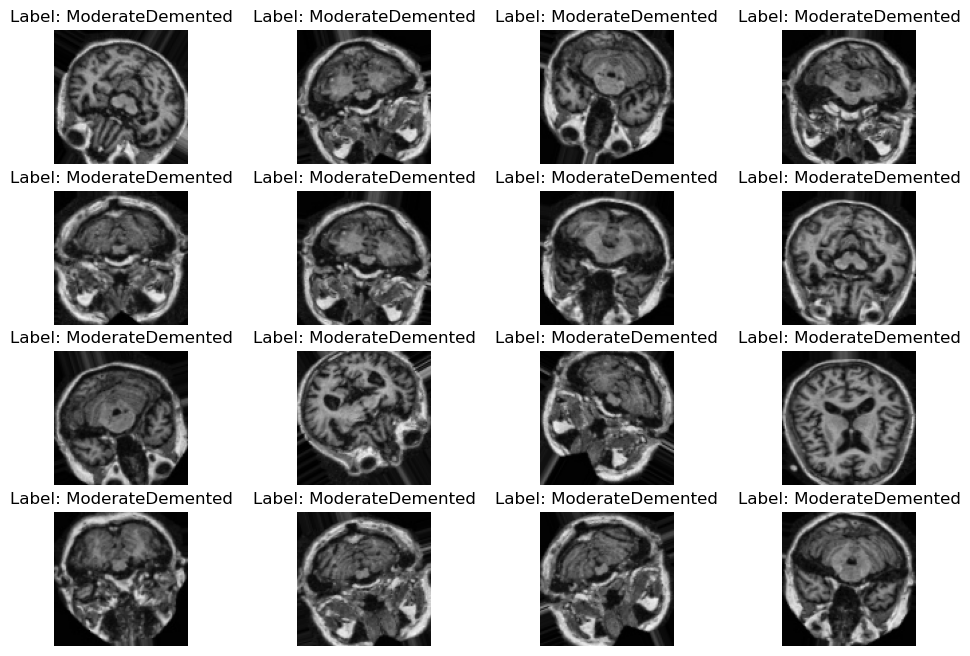

In [7]:
#Show augmented images of Mild and Moderate
random_indices = random.sample(range(len(augimage)), 16)

mtplt.figure(figsize = (12,8))
for i, index in enumerate(random_indices):
    mtplt.subplot(4, 4, i+1)
    mtplt.imshow(augimage[index])
    mtplt.title(f'Label: {auglabel[index]}')
    mtplt.axis('off')

In [8]:
#Load image for train, test and validation
clslbl = {}
for label, clss in enumerate(classes):
    clslbl[clss] = label
    
x_train = []
y_train= []

for folder in os.listdir(train_path):
    subpath = os.path.join(train_path,folder)
    label = clslbl[folder]
    
    for images in os.listdir(subpath):
        imagepath = os.path.join(subpath,images)
        imageArray = cv2.imread(imagepath)
        x_train.append(imageArray)
        y_train.append(label)
            
x_test= []
y_test= []

for folder in os.listdir(test_path):
    subpath = os.path.join(test_path,folder)
    label = clslbl[folder]
    
    for images in os.listdir(subpath):
        imagepath = os.path.join(subpath,images)
        imageArray = cv2.imread(imagepath)
        x_test.append(imageArray)
        y_test.append(label)
        
x_val= []
y_val= []

for folder in os.listdir(val_path):
    subpath = os.path.join(val_path,folder)
    label = clslbl[folder]
    
    for images in os.listdir(subpath):
        imagepath = os.path.join(subpath,images)
        imageArray = cv2.imread(imagepath)
        x_val.append(imageArray)
        y_val.append(label)

In [9]:
#Normalize image
train_x = np.array(x_train)/255.0
train_y = np.array(y_train)
test_x = np.array(x_test)/255.0
test_y = np.array(y_test)
val_x = np.array(x_val)/255.0
val_y = np.array(y_val)

In [10]:
print(train_x.shape)
print(test_x.shape)
print(val_x.shape)

(4955, 100, 100, 3)
(467, 100, 100, 3)
(468, 100, 100, 3)


# Modelling

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer =Adam (learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       7

In [13]:
import tensorflow as tf
print("GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU Available:  0


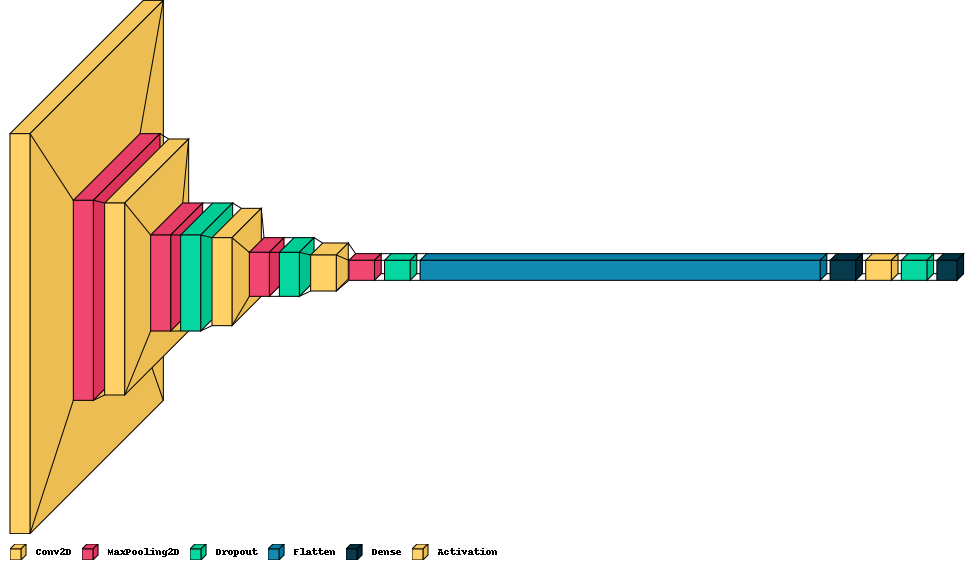

In [14]:
import visualkeras
from tensorflow.keras.models import load_model

#Visualization of the CNN model 

layer_names = ['conv1', 'conv2', 'flatten', 'dense1', 'dense2', 'output']
visualkeras.layered_view(model, to_file='output.png', legend=True)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss', 
                         mode='min', 
                         verbose=1, 
                         patience=3)

with tf.device('/GPU:0'):
    history = model.fit(train_x,
                        train_y,
                        validation_data = (val_x, val_y),
                        epochs=50,
                        callbacks=[early_stop],
                        shuffle = True)
    

model.save('ADModel22.keras')

Epoch 1/50
413/413 [==============================] - 59s 139ms/step - loss: 1.3585 - accuracy: 0.3092 - val_loss: 1.3461 - val_accuracy: 0.3846
Epoch 2/50
413/413 [==============================] - 58s 141ms/step - loss: 1.1795 - accuracy: 0.4513 - val_loss: 1.0788 - val_accuracy: 0.4316
Epoch 3/50
413/413 [==============================] - 60s 146ms/step - loss: 0.8507 - accuracy: 0.6109 - val_loss: 0.9490 - val_accuracy: 0.5449
Epoch 4/50
413/413 [==============================] - 62s 149ms/step - loss: 0.7551 - accuracy: 0.6488 - val_loss: 0.8950 - val_accuracy: 0.6197
Epoch 5/50
413/413 [==============================] - 59s 144ms/step - loss: 0.7129 - accuracy: 0.6785 - val_loss: 0.8682 - val_accuracy: 0.6132
Epoch 6/50
413/413 [==============================] - 58s 141ms/step - loss: 0.6732 - accuracy: 0.6945 - val_loss: 0.8675 - val_accuracy: 0.6432
Epoch 7/50
413/413 [==============================] - 57s 139ms/step - loss: 0.6463 - accuracy: 0.7112 - val_loss: 0.7713 - val_ac

In [16]:
print("Accuracy of the model is - " , model.evaluate(test_x,test_y)[1]*100 , "%")

15/15 [==============================] - 1s 62ms/step - loss: 0.2272 - accuracy: 0.9165
Accuracy of the model is -  91.64882302284241 %


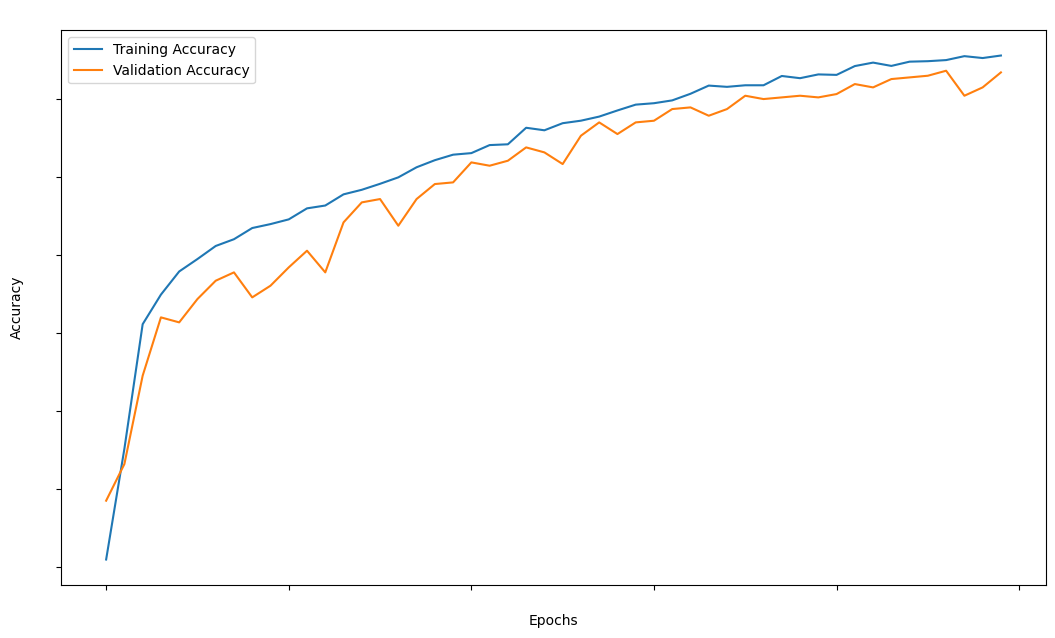

In [17]:
mtplt.figure(figsize=(12.7,7.2))
mtplt.title('Accuracies vs Epochs', color = 'white')
mtplt.plot(history.history['accuracy'], label='Training Accuracy')
mtplt.plot(history.history['val_accuracy'], label='Validation Accuracy')

mtplt.legend()
mtplt.xlabel('Epochs')
mtplt.ylabel('Accuracy')
mtplt.xticks(color='white')
mtplt.yticks(color='white')
mtplt.show()

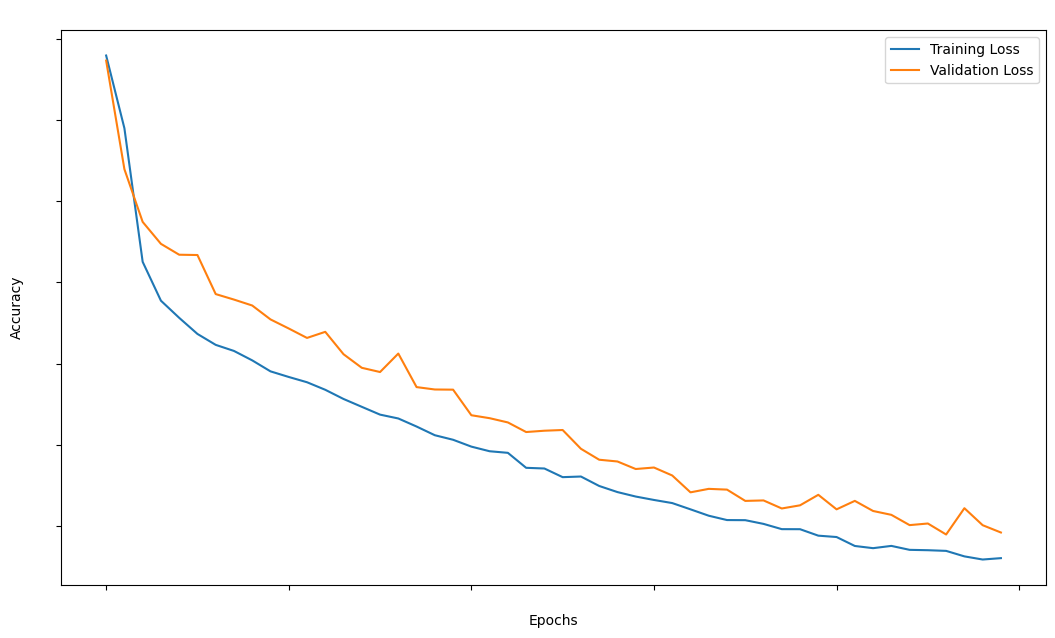

In [18]:
mtplt.figure(figsize=(12.7,7.2))
mtplt.title('Accuracies vs Epochs', color = 'white')
mtplt.plot(history.history['loss'], label='Training Loss')
mtplt.plot(history.history['val_loss'], label='Validation Loss')

mtplt.legend()
mtplt.xlabel('Epochs')
mtplt.ylabel('Accuracy')
mtplt.xticks(color='white')
mtplt.yticks(color='white')
mtplt.show()

In [19]:
y_predicts=model.predict(test_x)
y_pred=np.argmax(y_predicts,axis=1)

15/15 [==============================] - 1s 64ms/step


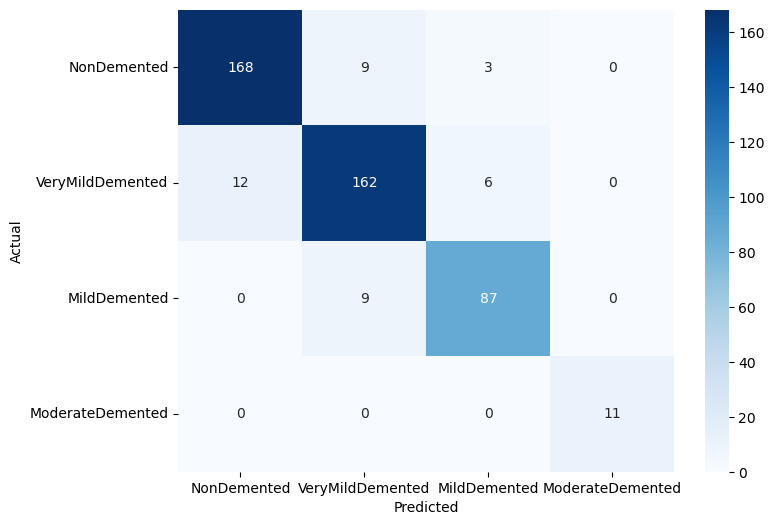

                  precision    recall  f1-score   support

     NonDemented       0.93      0.93      0.93       180
VeryMildDemented       0.90      0.90      0.90       180
    MildDemented       0.91      0.91      0.91        96
ModerateDemented       1.00      1.00      1.00        11

        accuracy                           0.92       467
       macro avg       0.93      0.93      0.93       467
    weighted avg       0.92      0.92      0.92       467



In [20]:
import seaborn as sns
import matplotlib.pyplot as mtplt

cm = confusion_matrix(test_y, y_pred)

mtplt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
mtplt.xlabel('Predicted')
mtplt.ylabel('Actual')

mtplt.show()
print(classification_report(test_y, y_pred, target_names=classes))

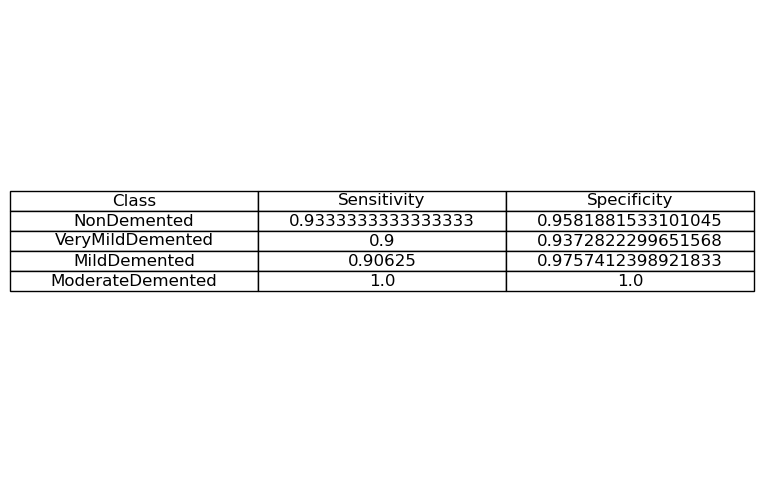

In [21]:
from sklearn.metrics import confusion_matrix

class_names = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

num_classes = len(class_names)

# Initialize lists to store sensitivity and specificity for each class
sensitivities = []
specificities = []

for class_index in range(num_classes):
    TP = cm[class_index, class_index]
    FN = sum(cm[class_index, :]) - TP
    TN = sum(cm[i, j] for i in range(num_classes) for j in range(num_classes) if i != class_index and j != class_index)
    FP = sum(cm[:, class_index]) - TP
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
     
    sensitivities.append(sensitivity)
    specificities.append(specificity)

table_data = [[f"{class_names[i]}", sensitivities[i], specificities[i]] for i in range(num_classes)]

mtplt.figure(figsize=(8, 6))
table = mtplt.table(cellText=table_data, loc='center', cellLoc='center', colLabels=['Class', 'Sensitivity', 'Specificity'])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
mtplt.axis('off')
mtplt.show()



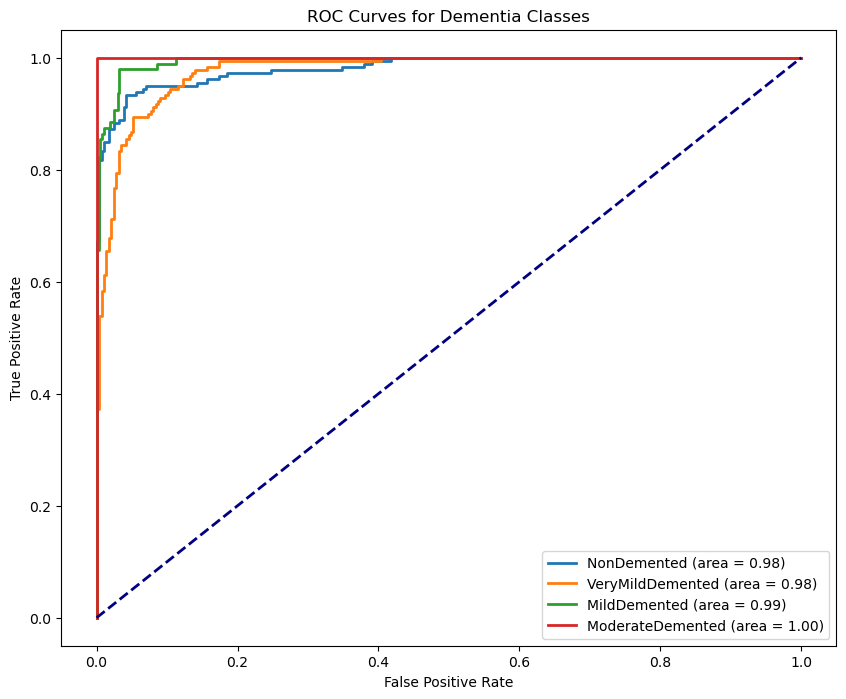

In [22]:
#ROC Curve

from sklearn.metrics import roc_curve, auc

num_classes = 4

mtplt.figure(figsize=(10, 8))

#Loop through each class
for i in range(num_classes):
    
    #Convert categorical labels to binary for class i
    y_true_class_i = (test_y == i).astype(int)
    
    #Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true_class_i, y_predicts[:, i])
    roc_auc = auc(fpr, tpr)
    
    #Plot ROC curve for class i and add class name to the label
    mtplt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (area = {roc_auc:.2f})')

#Plot the diagonal line representing random guessing
mtplt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
mtplt.xlabel('False Positive Rate')
mtplt.ylabel('True Positive Rate')
mtplt.title('ROC Curves for Dementia Classes')
mtplt.legend(loc='lower right')

# Show the plot
mtplt.show()


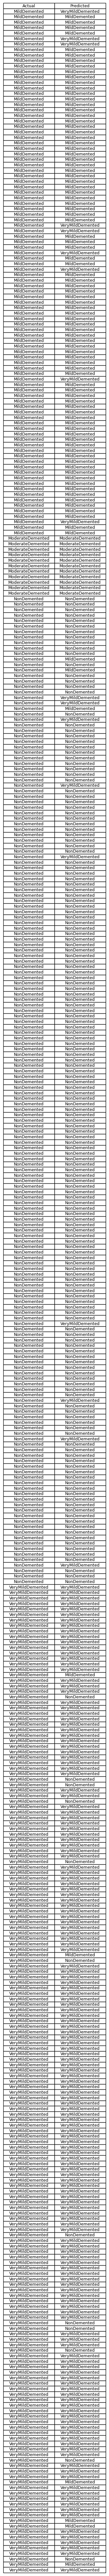

In [23]:
from tabulate import tabulate

y_pred_class = [classes[pred.argmax()] for pred in y_predicts]
y_true_class = [classes[true] for true in test_y]
df = pd.DataFrame({'Actual': y_true_class, 'Predicted': y_pred_class})

fig, ax = mtplt.subplots(figsize=(4, 4)) # Adjust the figsize as needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')
mtplt.show()
